In [1]:
!pip install ivon-opt

import torch
from torch import nn
from torch import Tensor
from torch.utils.data import DataLoader, Subset
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
import ivon

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28 * 28, 500),
            nn.ReLU(),
            nn.Linear(500, 300),
            nn.ReLU(),
            nn.Linear(300, 10),
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [3]:
# EWC wrapper
class EWC:
    def __init__(self, model, dataset, device='mps'):
        self.model = model
        self.device = device
        self.dataset = dataset
        self.model.eval()

        self.params = {n: p.clone().detach() for n, p in model.named_parameters() if p.requires_grad}
        self.fisher = self._compute_fisher()

    def _compute_fisher(self):
        fisher = {n: torch.zeros_like(p, device=self.device) for n, p in self.model.named_parameters() if p.requires_grad}
        data_loader = DataLoader(self.dataset, batch_size=1, shuffle=True)

        for x, y in data_loader:
            self.model.zero_grad()
            x, y = x.to(self.device), y.to(self.device)
            output = self.model(x)
            loss = nn.functional.cross_entropy(output, y)
            loss.backward()
            for n, p in self.model.named_parameters():
                if p.grad is not None:
                    fisher[n] += p.grad.detach() ** 2
        # Average over number of samples
        for n in fisher:
            fisher[n] /= len(self.dataset)
        return fisher

    def penalty(self, model):
        loss = 0
        for n, p in model.named_parameters():
            if p.requires_grad:
                _loss = self.fisher[n] * (p - self.params[n])**2
                loss += _loss.sum()
        return loss


In [4]:
def ece(preds, target, device, n_bins=100):
    confidences, predictions = torch.max(preds, 1)  # predicted class + confidence
    accuracies = predictions.eq(target)  # 1 if correct, 0 if not

    bin_boundaries = torch.linspace(0, 1, n_bins + 1, device=device)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]

    ece = torch.zeros(1, device=device)
    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = confidences.gt(bin_lower.item()) * confidences.le(bin_upper.item())
        prop_in_bin = in_bin.float().mean()
        if prop_in_bin.item() > 0:
            accuracy_in_bin = accuracies[in_bin].float().mean()
            avg_confidence_in_bin = confidences[in_bin].mean()
            ece += torch.abs(avg_confidence_in_bin - accuracy_in_bin) * prop_in_bin 

    return ece.item()


In [5]:
def train_loop_ivon(dataloader, model, loss_fn, optimizer, scheduler):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        for _ in range(train_samples):
            with optimizer.sampled_params(train=True):
                logit = model(X)
                loss = loss_fn(logit, y)
                loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        if batch % print_mod == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def train_loop_ivon_ewc(dataloader, model, loss_fn, optimizer, scheduler, ewc, lambda_ewc):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        for _ in range(train_samples):
            with optimizer.sampled_params(train=True):
                logit = model(X)
                loss = loss_fn(logit, y) + lambda_ewc * ewc.penalty(model)
                loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        if batch % print_mod == 0:
            loss, current = loss.item(), batch * batch_size + len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop_ivon(dataloader, model, optimizer, loss_fn, test_mc):
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    all_probs = []
    all_targets = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)

            if test_mc == 0:
                logit = model(X)
                prob = F.softmax(logit, dim=1)
                test_loss += loss_fn(logit, y).item()
                correct += (logit.argmax(1) == y).type(torch.float).sum().item()
            else:
                sampled_probs = []
                for i in range(test_mc):
                    with optimizer.sampled_params():
                        sampled_logit = model(X)
                        sampled_probs.append(F.softmax(sampled_logit, dim=1))
                prob = torch.mean(torch.stack(sampled_probs), dim=0)
                test_loss -= torch.sum(torch.log(prob.clamp(min=1e-6)) * F.one_hot(y, 10), dim=1).mean()
                _, pred = prob.max(1)
                correct += pred.eq(y).sum().item()

            all_probs.append(prob)
            all_targets.append(y)

    test_loss /= num_batches
    correct /= size

    # Concatenate all predictions and targets
    all_probs = torch.cat(all_probs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute ECE
    ece_score = ece(all_probs, all_targets, device)

    if test_mc != 0:
        print(f"\nIVON -- Test Performance with {test_mc:0d} Test Samples \n Accuracy: {(100 * correct):>0.2f}%, Avg loss: {test_loss:>7f}, ECE: {ece_score:.2f} \n")
    else:
        print(f"IVON -- Test Performance with Mean Prediction \n Accuracy: {(100 * correct):>0.2f}%, Avg loss: {test_loss:>7f}, ECE: {ece_score:.2f} \n")


In [6]:
def rklb(means, covs, weights=None):  # Kullback Leiber Average
    inverted_covs = [1/cov for cov in covs]
    cov = 1/(np.average(inverted_covs, weights=weights, axis=0))
    inverted_covs_time_means = [(inverted_covs[i] * means[i]) for i in range(len(means))]
    #cov = cov.reshape(-1,1)
    mu = cov * np.average(inverted_covs_time_means, weights=weights, axis=0)
    return mu, cov

def wb(means, covs, weights = None):
    #check if matrices are diagonal
    #assert all([ np.sum(K > 1e-10) == K.shape[0] for K in covs]), \
    #    "NotDiagonal: One of the covariance matrices is not diagonal."
    mu = np.average(means, weights=weights, axis=0)
    # cov = np.average([np.sqrt(K.cpu()) for K in covs], weights=weights, axis=0)**2   for ivon
    cov = np.average([np.sqrt(K) for K in covs], weights=weights, axis=0)**2
    return mu, cov


def flatten_model_state_dict(state_dict):
    vec = []
    for param_tensor in state_dict:
        vec.append(state_dict[param_tensor].view(-1))
    return torch.cat(vec)

def unflatten_model_state_dict(vec, state_dict):
    state_dict = state_dict.copy()
    idx = 0
    for param_tensor in state_dict:
        param = state_dict[param_tensor]
        size = param.numel()
        state_dict[param_tensor] = torch.from_numpy( vec[idx:idx+size].reshape(param.size()) )
        idx += size
    return state_dict


In [7]:
class IVON_SAMP(ivon.IVON):
    # A subclass of IVON that rewrites _sample_params
    # To make the sampling with a given covariance instead of the ess and the hess parameters in the original verison used to compute the covariance
    def __init__(self, *args, cov, **kwargs):
        super().__init__(*args, **kwargs)
        for group in self.param_groups:
            group["cov"] = cov
    def _sample_params(self) -> Tuple[Tensor, Tensor]:
            noise_samples = []
            param_avgs = []
            offset = 0
            for group in self.param_groups:
                gnumel = group["numel"]
                #noise_sample = (
                #    torch.randn(gnumel, device=self._device, dtype=self._dtype)
                #    / (
                #        group["ess"] * (group["hess"] + group["weight_decay"])
                #    ).sqrt()
                #)
                cov = group["cov"].astype(np.float32)
                if cov.ndim == 2:
                    cov = cov.squeeze(1)
                noise_sample = (
                    torch.randn(gnumel, device=self._device, dtype=torch.float32)
                    * torch.from_numpy(np.sqrt(cov)).to(self._device)
                )

                noise_samples.append(noise_sample)

                goffset = 0
                for p in group["params"]:
                    if p is None:
                        continue

                    p_avg = p.data.flatten()
                    numel = p.numel()
                    p_noise = noise_sample[offset : offset + numel]

                    param_avgs.append(p_avg)
                    p.data = (p_avg + p_noise).view(p.shape)
                    goffset += numel
                    offset += numel
                assert goffset == group["numel"]  # sanity check
            assert offset == self._numel  # sanity check

            return torch.cat(param_avgs, 0), torch.cat(noise_samples, 0)



In [8]:
torch.manual_seed(0)
device = 'mps'
loss_fn = nn.CrossEntropyLoss()

learning_rate = 1e-1
batch_size = 128
epochs = 5
weight_decay = 1e-4
momentum = 0.9
print_mod = 450

# Data A & B

In [9]:
transform_mnist = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
])

training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transform_mnist
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=transform_mnist
)


def split_by_class(dataset, classes_A, classes_B):
    idx_A = [i for i, (x, y) in enumerate(dataset) if y in classes_A]
    idx_B = [i for i, (x, y) in enumerate(dataset) if y in classes_B]
    return Subset(dataset, idx_A), Subset(dataset, idx_B)

training_dataA, training_dataB = split_by_class(training_data, classes_A={0,1,2,3,4}, classes_B={5,6,7,8,9})
test_dataA, test_dataB = split_by_class(test_data, classes_A={0,1,2,3,4}, classes_B={5,6,7,8,9})


train_dataloader_A = DataLoader(training_dataA, batch_size=batch_size)
test_dataloader_A = DataLoader(test_dataA, batch_size=batch_size)
train_dataloader_B = DataLoader(training_dataB, batch_size=batch_size)
test_dataloader_B = DataLoader(test_dataB, batch_size=batch_size)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9912422/9912422 [00:06<00:00, 1601348.97it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28881/28881 [00:00<00:00, 201168.95it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1648877/1648877 [00:01<00:00, 1086143.80it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4542/4542 [00:00<00:00, 2155524.87it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



# Model A

In [10]:
modelA = NeuralNetwork().to(device)

h0 = 0.01
train_samples = 1
optimizerA = ivon.IVON(modelA.parameters(), lr=learning_rate, ess=len(training_dataA), weight_decay=weight_decay, beta1=momentum, hess_init=h0)
schedulerA = CosineAnnealingLR(optimizerA, T_max=epochs, eta_min=0)

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop_ivon(train_dataloader_A, modelA, loss_fn, optimizerA, schedulerA)



Epoch 1
-------------------------------
loss: 2.878137  [  128/30596]
Epoch 2
-------------------------------
loss: 0.319461  [  128/30596]
Epoch 3
-------------------------------
loss: 0.308622  [  128/30596]
Epoch 4
-------------------------------
loss: 0.197658  [  128/30596]
Epoch 5
-------------------------------
loss: 0.178712  [  128/30596]


In [11]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_A, modelA, optimizerA, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_A, modelA, optimizerA, loss_fn, test_mc64)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 97.55%, Avg loss: 0.084325, ECE: 0.01 


IVON -- Test Performance with 64 Test Samples 
 Accuracy: 97.63%, Avg loss: 0.082286, ECE: 0.02 



# Model B

In [12]:
modelB = NeuralNetwork().to(device)

h0 = 0.01
train_samples = 1
optimizerB = ivon.IVON(modelB.parameters(), lr=learning_rate, ess=len(training_dataB), weight_decay=weight_decay, beta1=momentum, hess_init=h0)
schedulerB = CosineAnnealingLR(optimizerB, T_max=epochs, eta_min=0)

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop_ivon(train_dataloader_B, modelB, loss_fn, optimizerB, schedulerB)



Epoch 1
-------------------------------
loss: 4.418577  [  128/29404]
Epoch 2
-------------------------------
loss: 0.294143  [  128/29404]
Epoch 3
-------------------------------
loss: 0.340823  [  128/29404]
Epoch 4
-------------------------------
loss: 0.283122  [  128/29404]
Epoch 5
-------------------------------
loss: 0.304606  [  128/29404]


## Test Model B on Data A

In [13]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_A, modelB, optimizerB, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_A, modelB, optimizerB, loss_fn, test_mc64)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 0.00%, Avg loss: 6.840128, ECE: 0.77 


IVON -- Test Performance with 64 Test Samples 
 Accuracy: 0.00%, Avg loss: 7.973606, ECE: 0.75 



## Test Model B on Data B

In [14]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_B, modelB, optimizerB, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_B, modelB, optimizerB, loss_fn, test_mc64)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 94.71%, Avg loss: 0.167037, ECE: 0.02 


IVON -- Test Performance with 64 Test Samples 
 Accuracy: 94.86%, Avg loss: 0.163708, ECE: 0.03 



# Barycenter of Models A and B

In [15]:
mu_A = modelA.state_dict()
mu_B = modelB.state_dict()

ess_A = optimizerA.state_dict()['param_groups'][0]['ess']
hess_A = optimizerA.state_dict()['param_groups'][0]['hess']
wd_A = optimizerA.state_dict()['param_groups'][0]['weight_decay']
cov_A =  1 / (ess_A * hess_A + wd_A)

ess_B = optimizerB.state_dict()['param_groups'][0]['ess']
hess_B = optimizerB.state_dict()['param_groups'][0]['hess']
wd_B = optimizerB.state_dict()['param_groups'][0]['weight_decay']
cov_B =  1 / (ess_B * hess_B + wd_B)

means = [flatten_model_state_dict(mu_A), flatten_model_state_dict(mu_B)]
means = torch.stack(means).cpu()
covs = [cov_A.cpu(), cov_B.cpu()]


## WB

In [16]:
mu_wb , cov_wb = wb(means, covs, weights=[0.5,0.5])
mu_wb_dict = unflatten_model_state_dict(mu_wb, mu_A)

In [17]:
model_wb = NeuralNetwork().to(device)
model_wb.load_state_dict(mu_wb_dict)
optimizer_wb = IVON_SAMP(model_wb.parameters(), lr=learning_rate, ess=1, weight_decay=weight_decay, beta1=momentum, hess_init=h0, cov=cov_wb)

In [18]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_A, model_wb, optimizer_wb, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_A, model_wb, optimizer_wb, loss_fn, test_mc0)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 59.72%, Avg loss: 1.973967, ECE: 0.44 

IVON -- Test Performance with Mean Prediction 
 Accuracy: 59.72%, Avg loss: 1.973967, ECE: 0.44 



In [19]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_B, model_wb, optimizer_wb, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_B, model_wb, optimizer_wb, loss_fn, test_mc0)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 88.89%, Avg loss: 1.785829, ECE: 0.71 

IVON -- Test Performance with Mean Prediction 
 Accuracy: 88.89%, Avg loss: 1.785829, ECE: 0.71 



## RKLB

In [20]:
mu_rklb , cov_rklb = rklb(means, covs, weights=[0.5,0.5])
mu_rklb_dict = unflatten_model_state_dict(mu_rklb, mu_A)

In [21]:
model_rklb = NeuralNetwork().to(device)
model_rklb.load_state_dict(mu_rklb_dict)
optimizer_rklb = IVON_SAMP(model_rklb.parameters(), lr=learning_rate, ess=1, weight_decay=weight_decay, beta1=momentum, hess_init=h0, cov=cov_rklb)

In [22]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_A, model_rklb, optimizer_rklb, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_A, model_rklb, optimizer_rklb, loss_fn, test_mc0)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 66.34%, Avg loss: 1.916755, ECE: 0.50 

IVON -- Test Performance with Mean Prediction 
 Accuracy: 66.34%, Avg loss: 1.916755, ECE: 0.50 



In [23]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_B, model_rklb, optimizer_rklb, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_B, model_rklb, optimizer_rklb, loss_fn, test_mc0)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 85.72%, Avg loss: 1.812394, ECE: 0.69 

IVON -- Test Performance with Mean Prediction 
 Accuracy: 85.72%, Avg loss: 1.812394, ECE: 0.69 



# Model C : Model A finetuned on Data B

In [24]:
modelC = NeuralNetwork().to(device)
modelC.load_state_dict(modelA.state_dict())

h0 = 0.01
train_samples = 1
optimizerC = ivon.IVON(modelC.parameters(), lr=learning_rate, ess=len(training_dataB), weight_decay=weight_decay, beta1=momentum, hess_init=h0)
schedulerC = CosineAnnealingLR(optimizerC, T_max=epochs, eta_min=0)
epochs = 5

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop_ivon(train_dataloader_B, modelC, loss_fn, optimizerC, schedulerC)



Epoch 1
-------------------------------
loss: 9.169736  [  128/29404]
Epoch 2
-------------------------------
loss: 0.398014  [  128/29404]
Epoch 3
-------------------------------
loss: 0.239808  [  128/29404]
Epoch 4
-------------------------------
loss: 0.252606  [  128/29404]
Epoch 5
-------------------------------
loss: 0.276946  [  128/29404]


In [25]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_A, modelC, optimizerC, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_A, modelC, optimizerC, loss_fn, test_mc64)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 0.00%, Avg loss: 7.488332, ECE: 0.81 


IVON -- Test Performance with 64 Test Samples 
 Accuracy: 0.00%, Avg loss: 7.368155, ECE: 0.76 



In [26]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_B, modelC, optimizerC, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_B, modelC, optimizerC, loss_fn, test_mc64)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 95.43%, Avg loss: 0.134957, ECE: 0.02 


IVON -- Test Performance with 64 Test Samples 
 Accuracy: 95.68%, Avg loss: 0.136107, ECE: 0.03 



# Model D : Model A finetuned on Data B with EWC 


In [27]:
ewc = EWC(modelA, training_dataA, device=device)

In [28]:
lambda_ewc = 1000
modelD = NeuralNetwork().to(device)
modelD.load_state_dict(modelA.state_dict())
modelD.train()
optimizerD = ivon.IVON(modelD.parameters(), lr=learning_rate, ess=len(training_dataB), weight_decay=weight_decay, beta1=momentum, hess_init=h0)
schedulerD = CosineAnnealingLR(optimizerD, T_max=epochs, eta_min=0)

In [29]:
epochs = 5

for t in range(epochs):
    print(f"Epoch {t + 1}\n-------------------------------")
    train_loop_ivon_ewc(train_dataloader_B, modelD, loss_fn, optimizerD, schedulerD, ewc, lambda_ewc)



Epoch 1
-------------------------------
loss: 76.520302  [  128/29404]
Epoch 2
-------------------------------
loss: 54.231518  [  128/29404]
Epoch 3
-------------------------------
loss: 46.042336  [  128/29404]
Epoch 4
-------------------------------
loss: 41.148136  [  128/29404]
Epoch 5
-------------------------------
loss: 37.564037  [  128/29404]


In [30]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_A, modelD, optimizerD, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_A, modelD, optimizerD, loss_fn, test_mc64)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 26.33%, Avg loss: 3.247081, ECE: 0.55 


IVON -- Test Performance with 64 Test Samples 
 Accuracy: 10.90%, Avg loss: 3.405192, ECE: 0.60 



In [31]:
# Predict at the mean of the variational posterior
test_mc0 = 0
test_loop_ivon(test_dataloader_B, modelD, optimizerD, loss_fn, test_mc0)

# Predict using samples
test_mc64 = 64
test_loop_ivon(test_dataloader_B, modelD, optimizerD, loss_fn, test_mc64)

IVON -- Test Performance with Mean Prediction 
 Accuracy: 94.32%, Avg loss: 0.177667, ECE: 0.02 


IVON -- Test Performance with 64 Test Samples 
 Accuracy: 94.86%, Avg loss: 0.168124, ECE: 0.04 



# Plots

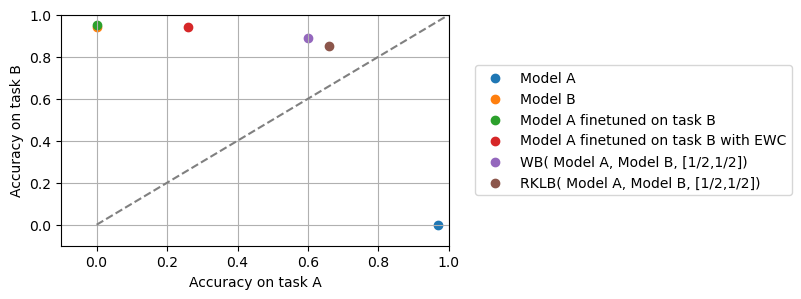

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# Example accuracy values for 4 models on domain A and B
model_names = ['Model A', 'Model B', 'Model C', 'Avg(A,B)']
accuracies = {
    'Model A': [0.97, 0],
    'Model B': [0, 0.94],
    'Model A finetuned on task B': [0, 0.95],
    'Model A finetuned on task B with EWC': [0.26, 0.94],
    'WB( Model A, Model B, [1/2,1/2])': [0.6, 0.89],
    'RKLB( Model A, Model B, [1/2,1/2])': [0.66, 0.85],
}
domains = ['Accuracy on task A', 'Accuracy on task B']

# Prepare data
df = pd.DataFrame(accuracies, index=domains).T

# 1. Radar Plot
def plot_radar(df):
    labels = df.columns.tolist()
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    for idx, row in df.iterrows():
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values, label=idx)
        ax.fill(angles, values, alpha=0.1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title("Radar Chart: Model Performance on A and B", y=1.1)
    ax.legend(loc='lower right')
    plt.show()

# 2. Grouped Bar Plot
def plot_grouped_bar(df):
    df_melted = df.reset_index().melt(id_vars='index', var_name='Domain', value_name='Accuracy')
    df_melted.rename(columns={'index': 'Model'}, inplace=True)
    plt.figure(figsize=(8, 6))
    sns.barplot(x='Domain', y='Accuracy', hue='Model', data=df_melted)
    plt.title("Grouped Bar Plot: Model Performance")
    plt.ylim(0, 1)
    plt.show()

# 3. Heatmap
def plot_heatmap(df):
    plt.figure(figsize=(6, 4))
    sns.heatmap(df, annot=True, cmap='Blues', vmin=0, vmax=1, fmt=".2f")
    plt.title("Heatmap: Accuracy of Models on A and B")
    plt.ylabel("Model")
    plt.xlabel("Domain")
    plt.show()

# 4. Scatter Plot
def plot_scatter(df):
    plt.figure(figsize=(5, 3))
    for model in df.index:
        x, y = df.loc[model, 'Accuracy on task A'], df.loc[model, 'Accuracy on task B']
        plt.scatter(x, y, label=model)
        #plt.text(x + 0.005, y, model, fontsize=9)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # diagonal
    plt.xlim(-0.1, 1.0)
    plt.ylim(-0.1, 1.0)
    plt.xlabel("Accuracy on task A")
    plt.ylabel("Accuracy on task B")
    #plt.title("Scatter Plot: Accuracy Trade-off between A and B")
    plt.legend( loc='center left',
                  bbox_to_anchor=(1.05, 0.5))
    plt.grid(True)
    plt.savefig("scatter_plot.pdf", bbox_inches='tight')
    plt.show()


plot_scatter(df)
